In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Load the dataset generated in Notebook 2
df = pd.read_pickle(INPUT_FILE)
print(f"Dataset loaded: {df.shape} rows")
print(f"Columns: {list(df.columns)}")

Dataset loaded: (74759, 19) rows
Columns: ['review_text', 'review_en', 'rating', 'date', 'user_total_reviews', 'user_id', 'is_local_guide', 'lang', 'park_name', 'text_length', 'year', 'month', 'quarter', 'month_name', 'season', 'gender', 'text_bert', 'text_stats', 'text_en_clean']


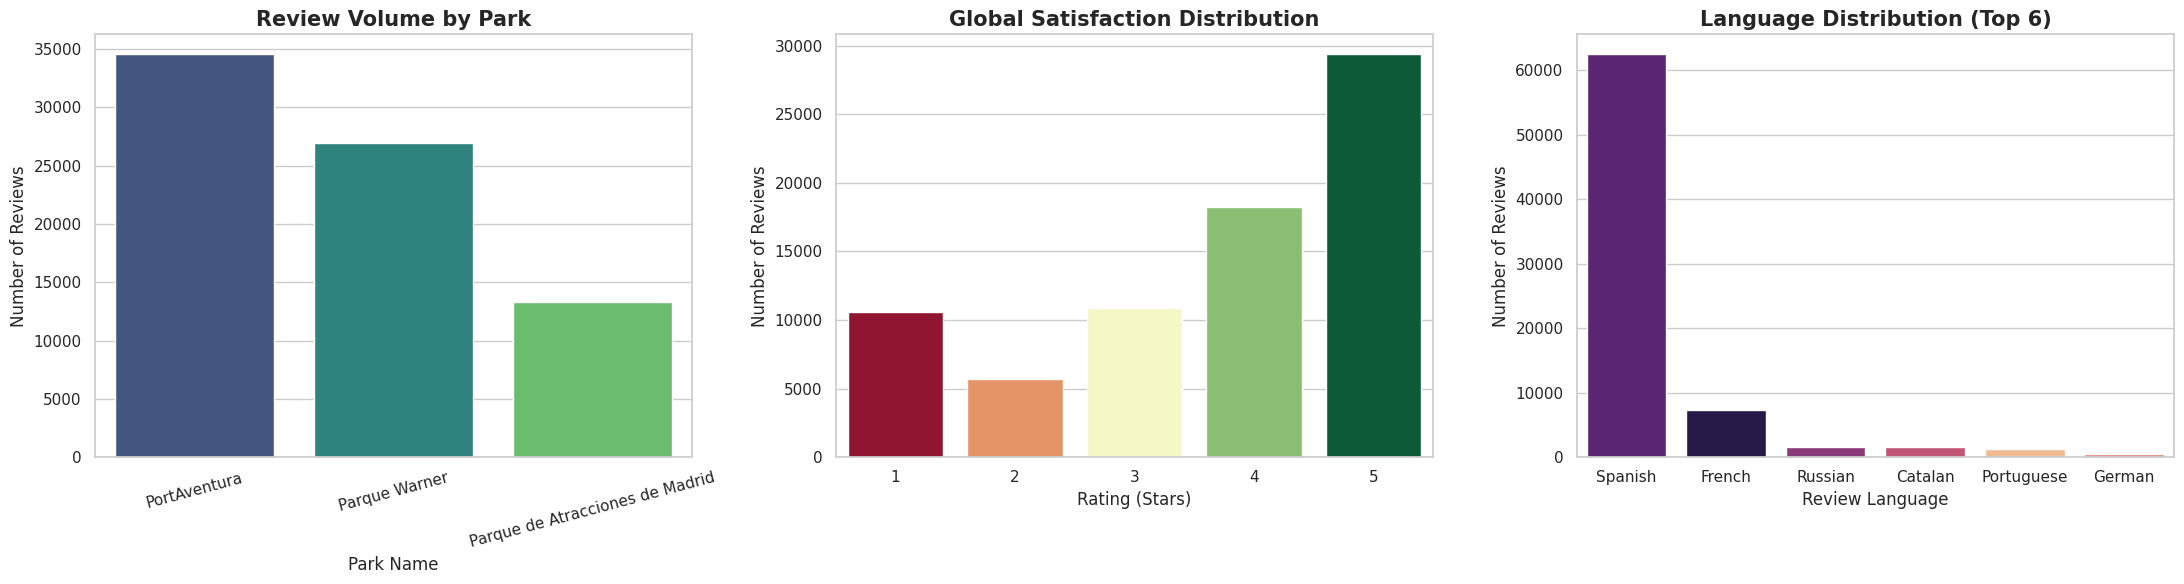

In [ ]:
# ==============================================================================
# General distribution analysis
# ==============================================================================

# Mapping for clearer language labels
language_map = {
    "es": "Spanish",
    "fr": "French",
    "ru": "Russian",
    "ca": "Catalan",
    "pt": "Portuguese",
    "de": "German"
}

df_plot = df.copy()
df_plot["Language"] = df_plot["lang"].map(language_map)

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Review volume by park
sns.countplot(
    x="park_name",
    hue="park_name",
    data=df_plot,
    ax=axes[0],
    palette="viridis",
    order=df_plot["park_name"].value_counts().index,
    legend=False
)
axes[0].set_title("Review Volume by Park", fontsize=15, fontweight="bold")
axes[0].set_xlabel("Park Name")
axes[0].set_ylabel("Number of Reviews")
axes[0].tick_params(axis="x", rotation=15)

# Global rating distribution
sns.countplot(
    x="rating",
    hue="rating",
    data=df_plot,
    ax=axes[1],
    palette="RdYlGn",
    legend=False
)
axes[1].set_title("Global Satisfaction Distribution", fontsize=15, fontweight="bold")
axes[1].set_xlabel("Rating (Stars)")
axes[1].set_ylabel("Number of Reviews")

# Top 6 languages
top_languages = df_plot["Language"].value_counts().head(6).index
sns.countplot(
    x="Language",
    hue="Language",
    data=df_plot[df_plot["Language"].isin(top_languages)],
    ax=axes[2],
    palette="magma",
    order=top_languages,
    legend=False
)
axes[2].set_title("Language Distribution (Top 6)", fontsize=15, fontweight="bold")
axes[2].set_xlabel("Review Language")
axes[2].set_ylabel("Number of Reviews")

plt.tight_layout()
plt.show()

/tmp/ipython-input-3224462405.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month_year"] = df["date"].dt.to_period("M")


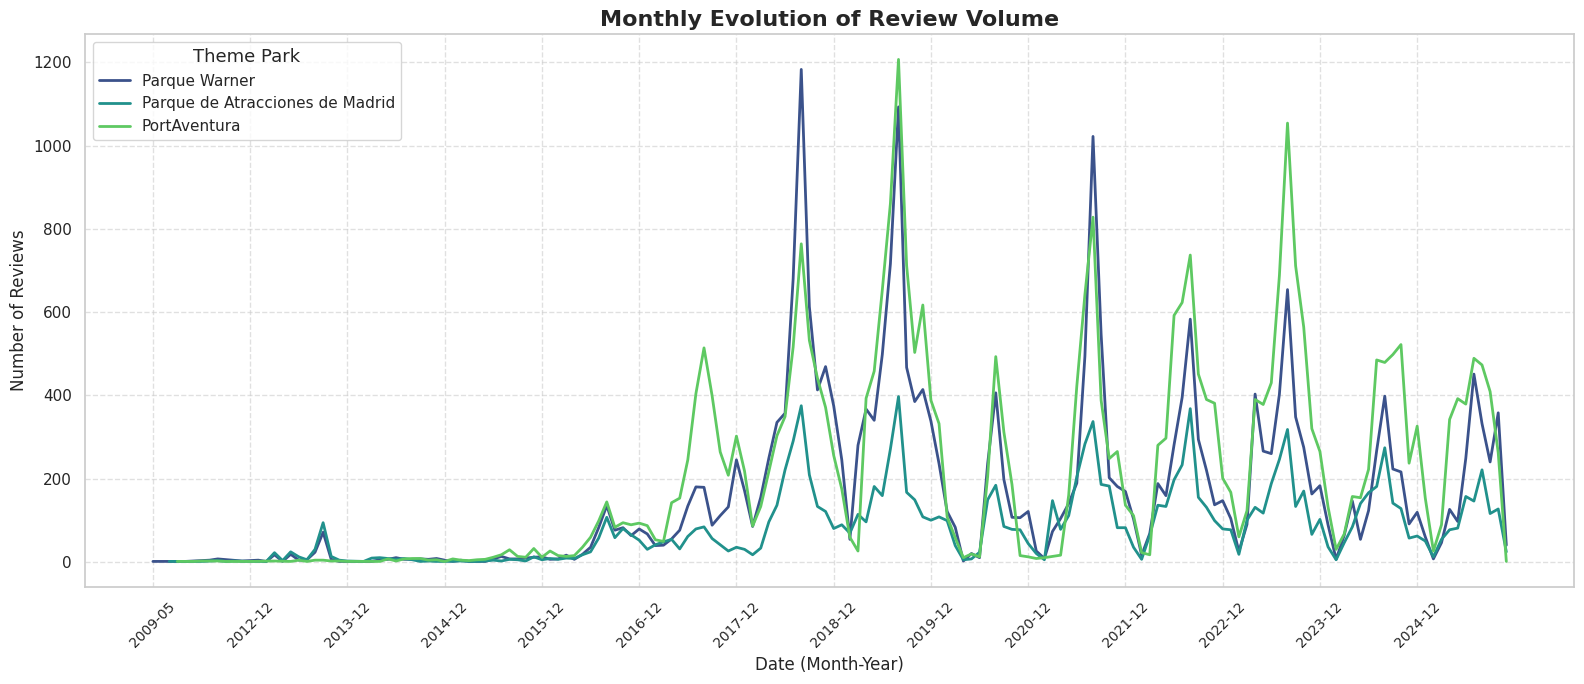

In [ ]:
# ==============================================================================
# Monthly evolution of review volume
# ==============================================================================

# Prepare data
df["month_year"] = df["date"].dt.to_period("M")
reviews_per_month = (
    df.groupby(["month_year", "park_name"])
      .size()
      .reset_index(name="counts")
)

# Convert to string for proper X-axis handling in Matplotlib
reviews_per_month["month_year"] = reviews_per_month["month_year"].astype(str)

# Plot
plt.figure(figsize=(16, 7))
sns.lineplot(
    data=reviews_per_month,
    x="month_year",
    y="counts",
    hue="park_name",
    palette="viridis",
    linewidth=2
)

# Formatting
plt.title("Monthly Evolution of Review Volume", fontsize=16, fontweight="bold")
plt.xlabel("Date (Month-Year)", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.legend(title="Theme Park", title_fontsize=13, fontsize=11, loc="upper left")

# Show one X-tick every 12 months
ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticks(xticks[::12])
plt.xticks(rotation=45, fontsize=10)

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

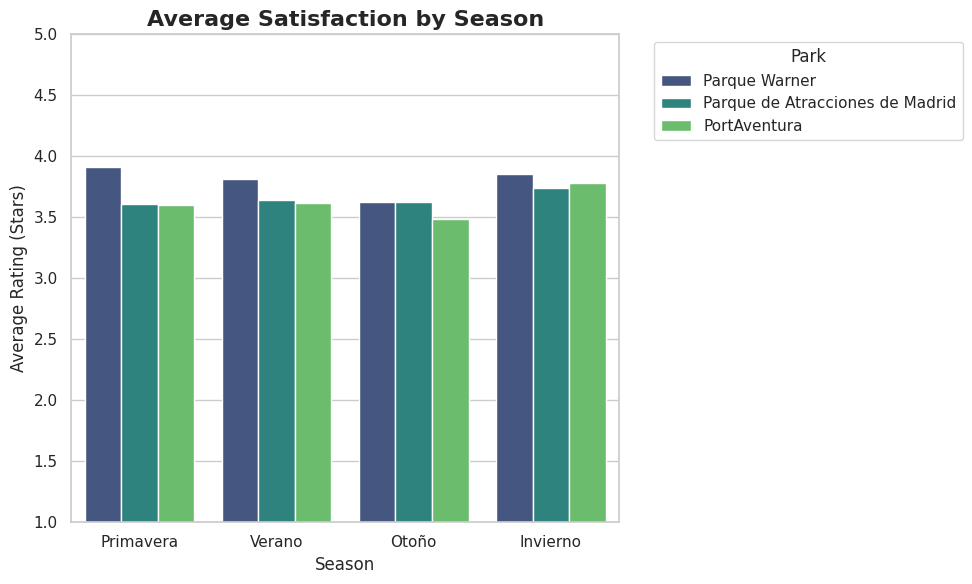

In [ ]:
# ==============================================================================
# Seasonal analysis
# ==============================================================================

# Season label mapping (English → Spanish)
season_map = {
    "Spring": "Primavera",
    "Summer": "Verano",
    "Autumn": "Otoño",
    "Winter": "Invierno"
}

# Map season names before aggregation
df_plot = df.copy()
df_plot["season"] = df_plot["season"].map(season_map)

# Compute average rating per season and park
avg_rating_season = (
    df_plot.groupby(["park_name", "season"])["rating"]
           .mean()
           .reset_index()
)

plt.figure(figsize=(10, 6))

# Barplot with explicit season order
sns.barplot(
    data=avg_rating_season,
    x="season",
    y="rating",
    hue="park_name",
    palette="viridis",
    order=["Primavera", "Verano", "Otoño", "Invierno"]
)

plt.title("Average Satisfaction by Season", fontsize=16, fontweight="bold")
plt.xlabel("Season", fontsize=12)
plt.ylabel("Average Rating (Stars)", fontsize=12)
plt.ylim(1, 5)

plt.legend(title="Park", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

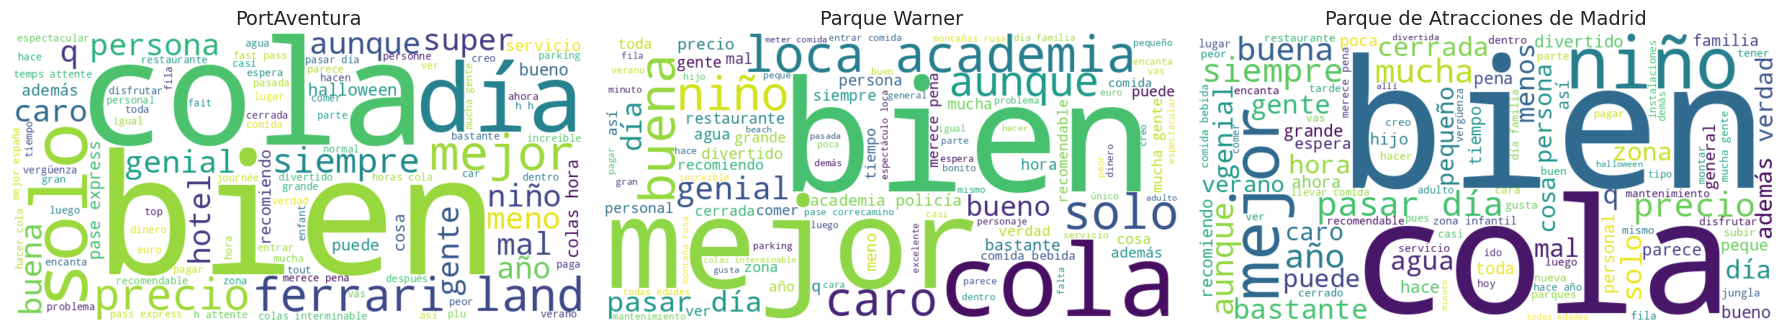

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ==============================================================================
# Word cloud generation
# ==============================================================================

def generate_wc_subplot(ax, text_series, title):
    """Render a word cloud into a given subplot axis."""
    text = " ".join(text_series.astype(str)).strip()

    if text:
        wc = WordCloud(
            width=800,
            height=400,
            background_color="white",
            max_words=100,
            colormap="viridis"
        ).generate(text)

        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(title, fontsize=14)
    else:
        ax.text(
            0.5, 0.5,
            "No valid words available",
            ha="center", va="center",
            fontsize=12
        )
        ax.axis("off")
        ax.set_title(title, fontsize=14)


# Parks in order
parks = df["park_name"].unique().tolist()

# Ensure exactly 3 subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, park in zip(axes, parks):
    subset = df[df["park_name"] == park]
    generate_wc_subplot(ax, subset["text_stats"], park)

plt.tight_layout()
plt.show()

In [ ]:
# List of parks
parks_list = df["park_name"].unique().tolist()

def analyze_ngrams(df_subset, n_range=(2, 2), top_k=10, title_suffix="", plot=False):
    """Compute top TF-IDF n-grams for a subset of the dataset."""
    from sklearn.feature_extraction.text import TfidfVectorizer

    texts = df_subset["text_stats"].dropna().astype(str).tolist()

    vectorizer = TfidfVectorizer(
        ngram_range=n_range,
        max_df=0.85,
        min_df=5,
        stop_words=None
    )

    tfidf_matrix = vectorizer.fit_transform(texts)
    scores = tfidf_matrix.sum(axis=0).A1
    terms = vectorizer.get_feature_names_out()

    df_scores = (
        pd.DataFrame({"ngram": terms, "score": scores})
        .sort_values("score", ascending=False)
        .head(top_k)
    )

    if plot:
        plt.figure(figsize=(10, 5))
        sns.barplot(data=df_scores, y="ngram", x="score", palette="viridis")
        plt.title(f"Top N-grams {title_suffix}")
        plt.tight_layout()
        plt.show()

    return df_scores

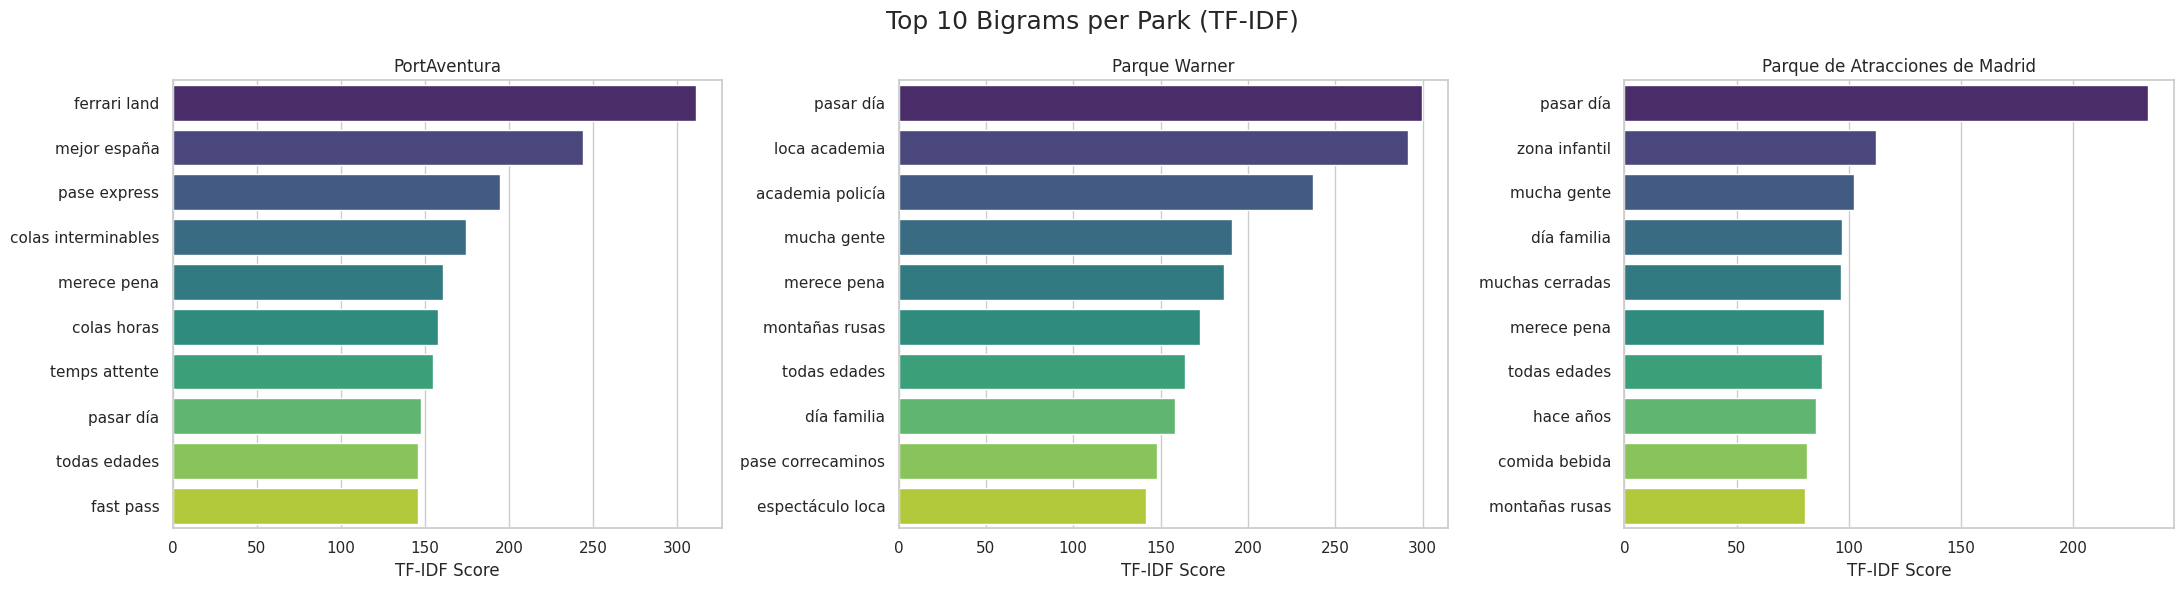

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
fig.suptitle("Top 10 Bigrams per Park (TF-IDF)", fontsize=18)

for i, park in enumerate(parks_list):
    df_park = df[df["park_name"] == park]

    top_ngrams = analyze_ngrams(
        df_park,
        n_range=(2, 2),
        top_k=10,
        title_suffix="",
        plot=False
    )

    sns.barplot(
        data=top_ngrams,
        y="ngram",
        x="score",
        hue="ngram",
        palette="viridis",
        legend=False,
        ax=axes[i]
    )

    axes[i].set_title(park)
    axes[i].set_xlabel("TF-IDF Score")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

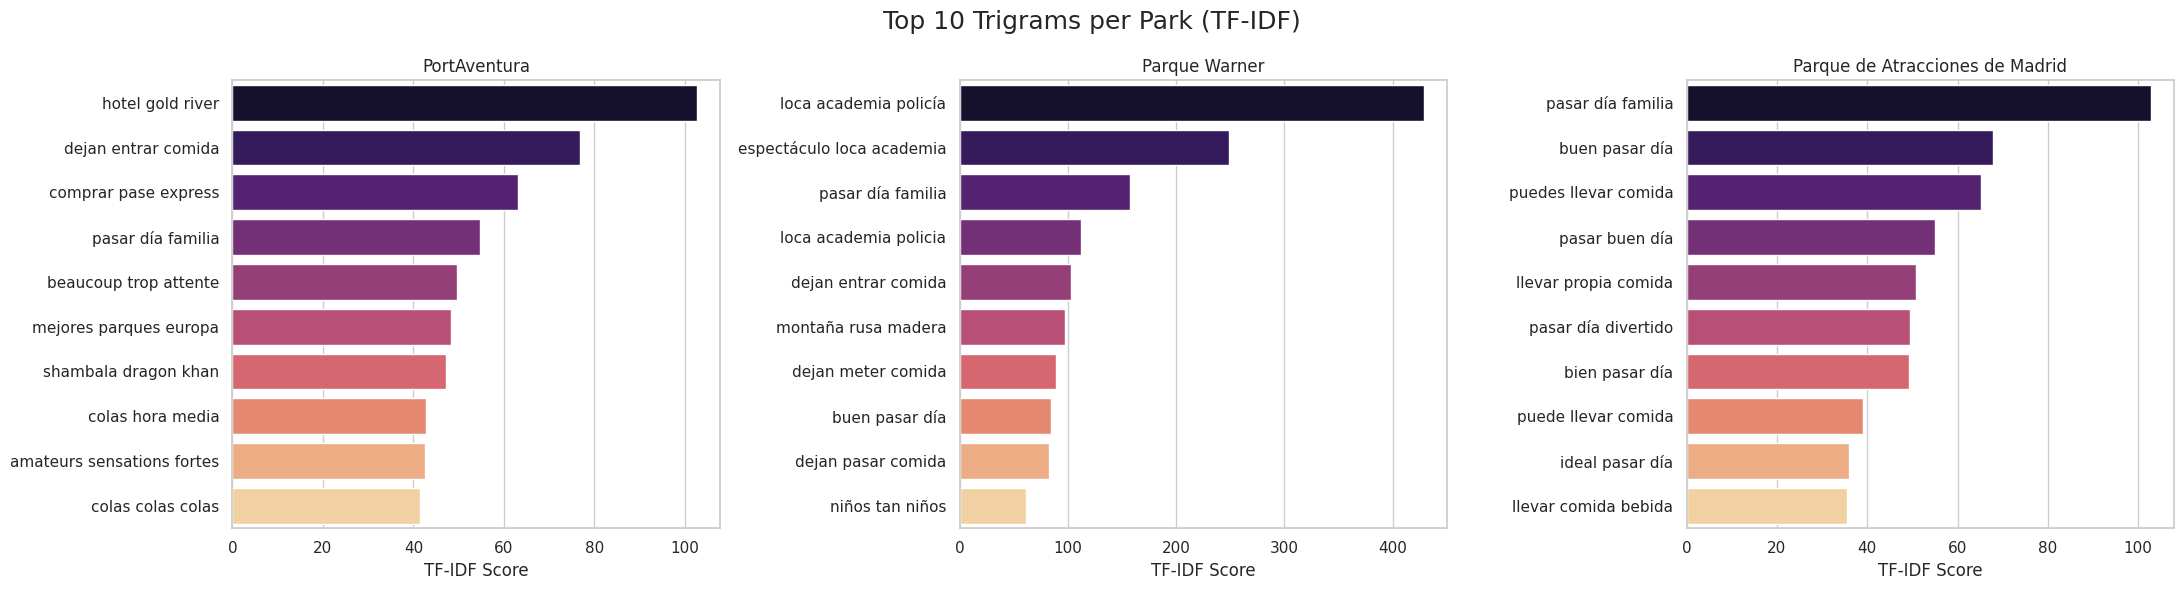

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
fig.suptitle("Top 10 Trigrams per Park (TF-IDF)", fontsize=18)

for i, park in enumerate(parks_list):
    df_park = df[df["park_name"] == park]

    top_ngrams = analyze_ngrams(
        df_park,
        n_range=(3, 3),
        top_k=10,
        title_suffix="",
        plot=False
    )

    sns.barplot(
        data=top_ngrams,
        y="ngram",
        x="score",
        hue="ngram",
        palette="magma",
        legend=False,
        ax=axes[i]
    )

    axes[i].set_title(park)
    axes[i].set_xlabel("TF-IDF Score")
    axes[i].set_ylabel("")

plt.tight_layout()
plt.show()